In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
# load plotly
import plotly.graph_objects as go
import plotly.express as px
plt.style.use('grayscale')

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1

%load_ext autoreload
%autoreload 2
%matplotlib inline

jan10dd.txt:

```
PEMLR        2      MONTHLY LABOR FORCE RECODE             180 - 181

                    EDITED UNIVERSE:   PRPERTYP = 2

                    VALID ENTRIES

                    1  EMPLOYED-AT WORK
                    2  EMPLOYED-ABSENT
                    3  UNEMPLOYED-ON LAYOFF
                    4  UNEMPLOYED-LOOKING
                    5  NOT IN LABOR FORCE-RETIRED
                    6  NOT IN LABOR FORCE-DISABLED
                    7  NOT IN LABOR FORCE-OTHER
````

```
HRINTSTA     2     INTERVIEW STATUS                        57 - 58

                   EDITED UNIVERSE: ALL HHLDs IN SAMPLE

                   VALID ENTRIES

                   1   INTERVIEW
                   2   TYPE A NON-INTERVIEW
                   3   TYPE B NON-INTERVIEW
                   4   TYPE C NON-INTERVIEW
```

In [2]:
def parse(fn):
    df = pd.read_fwf(fn, 
        header=None,
        colspecs=[(0,15), (17, 21), (15,17), (56, 58), (179,181), (121, 123), (23, 26)],
        names=['HRHHID', 'HRYEAR4', 'HRMONTH', 'HRINTSTA', 'PEMLR', 'PEAGE', 'HUFINAL'],
        dtype={0: "str"},
        )
    df['DATE'] = pd.to_datetime(df['HRYEAR4'].astype(str) + '-' + df['HRMONTH'].astype(str) + '-01')
    return df

# get list of files in a directory with *.dat extension
import glob
files = glob.glob('data/CPS/*.dat')
cps = []
for f in files:
    cps.append(parse(f))


In [3]:
def non_response_rate(df, _type=2):
    return df[df.HRINTSTA == _type].shape[0]/df.shape[0]

def type_a_non_response_rate(df, hufinal):
    return df[(df.HRINTSTA == 2) & (df.HUFINAL == hufinal)].shape[0]/df.shape[0]

def unit_non_response_fraction(df):
    eligible = df[df.PEAGE >= 16]
    type_a_non_response = df[df.HRINTSTA == 2]
    return type_a_non_response.shape[0]/(eligible.shape[0]+type_a_non_response.shape[0])

def unemployment_rate(df):
    eligible = df[df.PEAGE >= 16]
    unemployed = eligible[eligible.PEMLR.isin([3,4])]
    return unemployed.shape[0]/eligible.shape[0]

def unemployment_rate_lb(df):
    eligible = df[df.PEAGE >= 16]
    type_a_non_response = df[df.HRINTSTA == 2]
    unemployed = eligible[eligible.PEMLR.isin([3,4])]
    return unemployed.shape[0]/(eligible.shape[0]+type_a_non_response.shape[0])

def unemployment_rate_ub(df):
    eligible = df[df.PEAGE >= 16]
    type_a_non_response = df[df.HRINTSTA == 2]
    unemployed = eligible[eligible.PEMLR.isin([3,4])]
    return (unemployed.shape[0]+type_a_non_response.shape[0])/(eligible.shape[0]+type_a_non_response.shape[0])

In [4]:
non_response_rates_by_type = []
for df in cps:
    non_response_rates_by_type.append([df.DATE[0], 'Type A', non_response_rate(df, 2)])
    non_response_rates_by_type.append([df.DATE[0], 'Type B', non_response_rate(df, 3)])
    non_response_rates_by_type.append([df.DATE[0], 'Type C', non_response_rate(df, 4)])
non_response_rates_by_type = pd.DataFrame(non_response_rates_by_type, columns=['DATE', 'TYPE', 'RATE'])
non_response_rates_by_type = non_response_rates_by_type.set_index('DATE')

type_a_refusal_rate = []
for df in cps:
    type_a_refusal_rate.append([df.DATE[0], type_a_non_response_rate(df, 218)])
type_a_refusal_rate = pd.DataFrame(type_a_refusal_rate, columns=['DATE', 'RATE'])
type_a_refusal_rate = type_a_refusal_rate.set_index('DATE').sort_index()


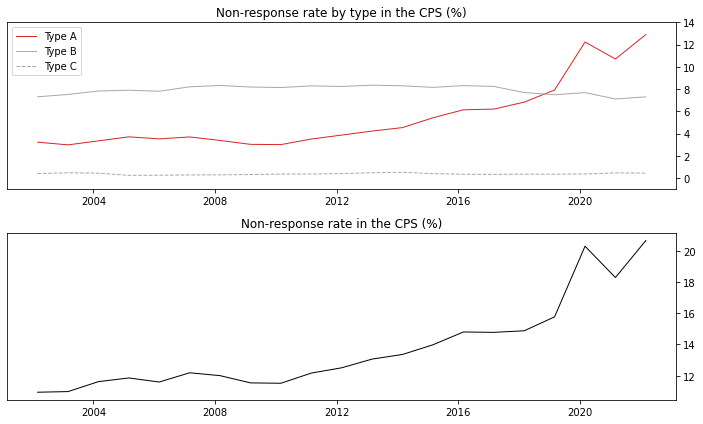

In [6]:
type_a = non_response_rates_by_type[non_response_rates_by_type.TYPE == 'Type A'].sort_index()
type_b = non_response_rates_by_type[non_response_rates_by_type.TYPE == 'Type B'].sort_index()
type_c = non_response_rates_by_type[non_response_rates_by_type.TYPE == 'Type C'].sort_index()
# set figure size
fig = plt.figure(figsize=(10,6))
# plot subplots
ax1 = fig.add_subplot(2,1,1)
ax1.plot(type_a.index, type_a.RATE*100, label='Type A', color='tab:red')
ax1.plot(type_b.index, type_b.RATE*100, label='Type B', color='darkgrey')
ax1.plot(type_c.index, type_c.RATE*100, label='Type C', color='darkgrey', linestyle='--')
ax1.set_title('Non-response rate by type in the CPS (%)')
# show y labels on the right side
ax1.yaxis.tick_right()
# set y-limits
ax1.set_ylim(-1, 14)
# add legend in top-left corner
ax1.legend(loc='upper left')

ax2 = fig.add_subplot(2,1,2)
non_response_rate = type_a+type_b+type_c
ax2.plot(non_response_rate.index, non_response_rate.RATE*100)
ax2.set_title('Non-response rate in the CPS (%)')
# show y labels on the right side
ax2.yaxis.tick_right()
# set tight layout
plt.tight_layout()
plt.show()

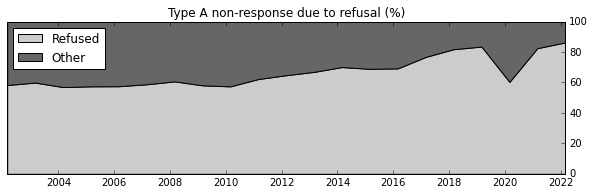

In [66]:
# set figure size
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(2,1,1)
total = type_a.RATE
ax1.stackplot(
    type_a.index, 
    type_a_refusal_rate.RATE/total*100, 
    (type_a.RATE-type_a_refusal_rate.RATE)/total*100, 
    labels=['Refused', 'Other'],
    colors=['#ccc', '#666'])
ax1.set_title('Type A non-response due to refusal (%)')
ax1.yaxis.tick_right()
plt.legend(loc='upper left')


It looks like since 2010, the refusal to participate in a survey rate grew from 2% to 11% in 2022.

In [9]:
unemployment = []
for df in cps:
    unemployment.append([
        df.DATE[0], 
        unit_non_response_fraction(df),
        unemployment_rate_lb(df),
        unemployment_rate(df),
        unemployment_rate_ub(df)
    ])
unemployment = pd.DataFrame(unemployment, columns=[
    'DATE', 'NON_RESPONSE_FRACTION', 'RATE_LOWER', 'RATE', 'RATE_UPPER'
])
unemployment = unemployment.set_index('DATE').sort_index()

In [10]:
unrate = pd.read_csv('data/UNRATE.csv')
unrate['DATE'] = pd.to_datetime(unrate['DATE'])
unrate = unrate[unrate.DATE >= '2002-03-01'].set_index('DATE')
unrate.UNRATE = unrate.UNRATE/100

# join unrate with unit_non_response_fraction_by_year
unemployment = unemployment.join(unrate.UNRATE, how='inner')

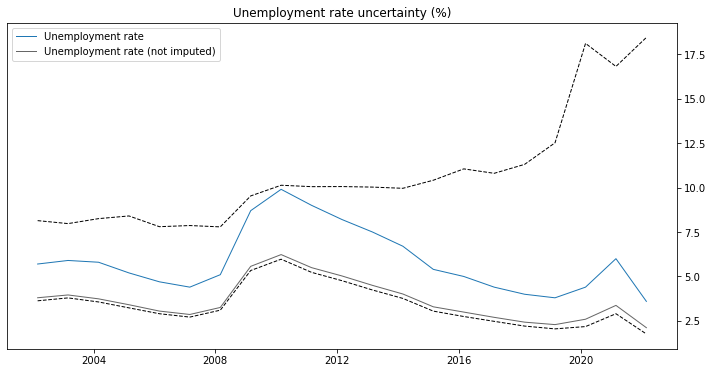

In [12]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
ax.plot(unemployment.UNRATE*100, label='Unemployment rate', color='tab:blue')
ax.plot(unemployment.RATE*100, color='#666',  
    label='Unemployment rate (not imputed)')
ax.plot(unemployment.RATE_LOWER*100, 'k--')
ax.plot(unemployment.RATE_UPPER*100, 'k--')
ax.set_title('Unemployment rate uncertainty (%)')
ax.yaxis.tick_right()
plt.legend(loc='upper left')
plt.show()

In [11]:
unemployment.tail()

,NON_RESPONSE_FRACTION,RATE_LOWER,RATE,RATE_UPPER,UNRATE
DATE,,,,,
2018-03-01,0.090924,0.022102,0.024313,0.113026,0.040
2019-03-01,0.104632,0.020534,0.022934,0.125166,0.038
2020-03-01,0.159218,0.021826,0.025959,0.181044,0.044
2021-03-01,0.139042,0.029048,0.033739,0.168090,0.060
2022-03-01,0.166716,0.017667,0.021201,0.184382,0.036


Getting the number of job opennings per unemployed person can by done by inverting the following stat, or just dividing other way around. Anyways, the data to look into is at: https://fred.stlouisfed.org/graph/?g=p9aA#0. This is something interesting to read also: https://www.bls.gov/news.release/jolts.nr0.htm.